In [4]:
import glob
import json
import os
import re
import time
import warnings
from datetime import datetime

import bs4
import missingno
import numpy as np
import pandas as pd
import pycep_correios as pycep
import requests as rq
import tqdm
from unidecode import unidecode

warnings.filterwarnings("ignore")

%config Completer.use_jedi = False 

In [5]:
path = './data/02_raw_df_w_end/'

# Nome dos arquivos dentro do diretorio acima (raw_df)
filenames = os.listdir(path)

# Dataframe dos dados sem tratamento
df = pd.read_csv(path + filenames[-1], sep='|') # -1 para pegar o ultimo dataframe adquirido

# Aplicando primeiro filtro para as colunas

In [6]:
# Fazendo o primeiro filtra para as colunas desnecessarias
cols =['list_id', 'link', 'title', 'price', 'condominio',
       'rooms', 'bathrooms', 'garage_spaces', 'size', 'sellername', 'desc', 'apartment_features', 'pictures', 
       'apartment_complex_features', 'zipcode', 'state', 'region', 'bairro', 'logradouro', 'latitude', 'complemento', 'longitude', 'altitude', 'source_x', 'iptu']

df = df[cols] # dataframe filtrado

# Limpeza dos dados

In [7]:
def trans_condominio(x):
    """ df['condominio'] str ---> float """
    if type(x) != float:
        x = int(x.split(' ')[1].replace('.', ''))
    else:
        x
    return x
 
def trans_bath_garage_rooms(value):
    """ df['bathroms'] e df['garage_spaces'] str ---> float """
    if value == '5 ou mais':
        return 5
    try:
        return int(value)
    except:
        return 0

In [8]:
df_cleaned = df.copy()

df_cleaned['condominio'] = df['condominio'].apply(trans_condominio)
df_cleaned['bathrooms'] = df['bathrooms'].apply(trans_bath_garage_rooms)
df_cleaned['garage_spaces'] = df['garage_spaces'].apply(trans_bath_garage_rooms)
df_cleaned['rooms'] = df['rooms'].apply(trans_bath_garage_rooms)

## Tratando as features: `desc`, `apartment_complex_features`, `apartment_features`, `city`, `bairro`, `logradouro`,`desc_full`

In [9]:
def clean_desc(desc):
    try:
        str_cleaned = desc.replace('\n', ' ').replace(',', ' ').replace(':', ' ').replace('/', ' ').replace('-', ' ')\
                    .replace('(', ' ').replace(')', ' ').replace('.', ' ')
        str_cleaned = unidecode(re.sub(' +', ' ', str_cleaned)).strip().lower()
        
        return str_cleaned

    except AttributeError as e:
        return ''

In [10]:
df_cleaned['desc'] = df_cleaned['desc'].apply(clean_desc)
df_cleaned['apartment_complex_features_rf'] = df_cleaned['apartment_complex_features'].apply(clean_desc)
df_cleaned['apartment_features_rf'] = df_cleaned['apartment_features'].apply(clean_desc)
df_cleaned['title'] = df_cleaned['title'].apply(clean_desc)
df_cleaned['region'] = df_cleaned['region'].apply(clean_desc)
df_cleaned['bairro'] = df_cleaned['bairro'].apply(clean_desc)
df_cleaned['logradouro'] = df_cleaned['logradouro'].apply(clean_desc)

# Agregando todos os descritivos
df_cleaned['desc_full'] = df_cleaned[['desc', 'apartment_features_rf', 'apartment_complex_features_rf']].agg(' '.join, axis=1)
df_cleaned['desc_full'] = df_cleaned['desc_full'].apply(clean_desc)

# Retirando as colunas descritivas redundantes
# df_cleaned = df_cleaned.drop(['desc', 'apartment_features','apartment_complex_features'], axis=1)

## Tratando dados faltantes

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   list_id                        2479 non-null   int64  
 1   link                           2479 non-null   object 
 2   title                          2479 non-null   object 
 3   price                          2477 non-null   float64
 4   condominio                     2320 non-null   float64
 5   rooms                          2479 non-null   int64  
 6   bathrooms                      2479 non-null   int64  
 7   garage_spaces                  2479 non-null   int64  
 8   size                           2470 non-null   float64
 9   sellername                     2479 non-null   object 
 10  desc                           2479 non-null   object 
 11  apartment_features             1521 non-null   object 
 12  pictures                       2479 non-null   f

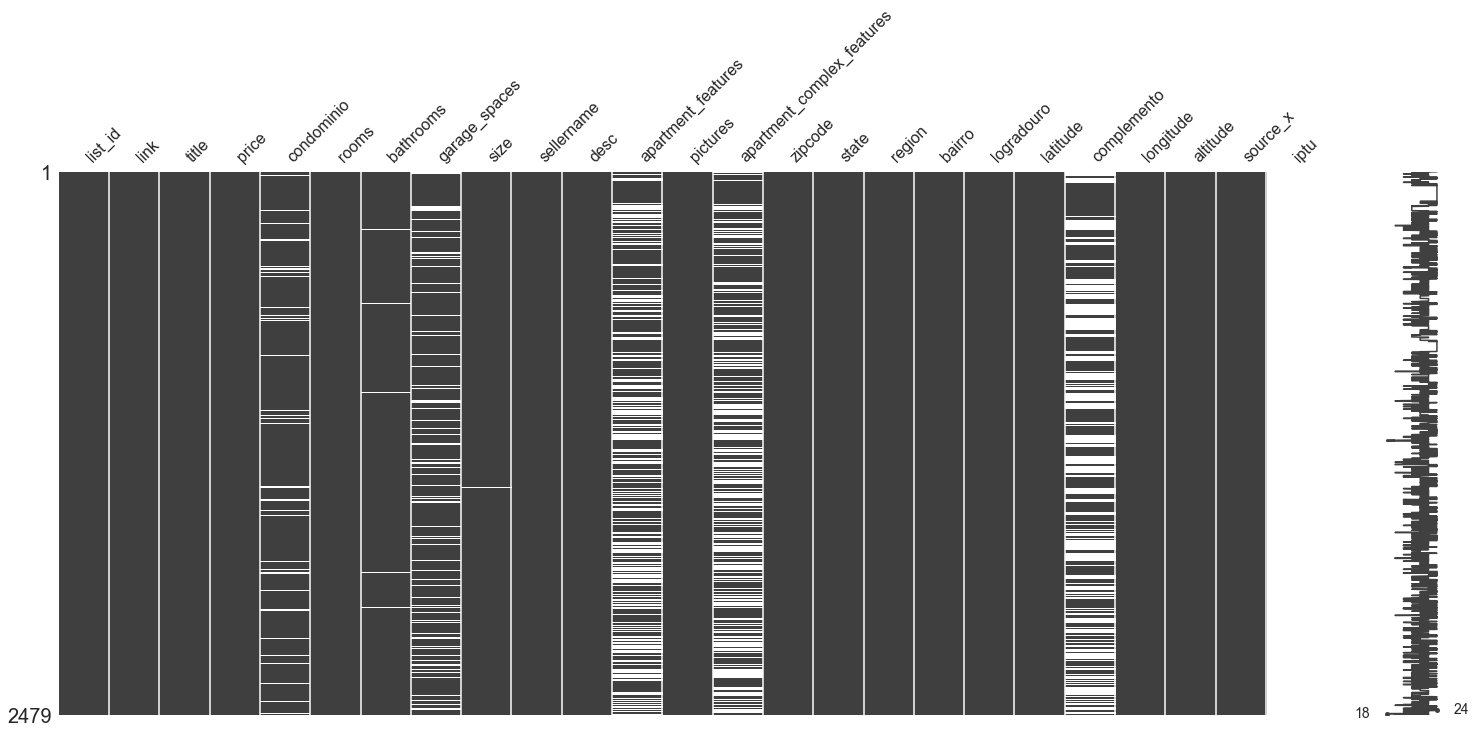

In [12]:
missingno.matrix(df);

In [13]:
def missing_values(df):
    """ funcao para calcular (em %) dados faltantes ou iguais a zero """
    
    print('Dados faltantes em %')
    print(round(df.isnull().sum() / df.shape[0], 2), '\n')
    print('='*25, '\n')
    print('Dados == 0 em %')
    print(round((df == 0).sum() / df.shape[0], 2))

In [14]:
missing_values(df_cleaned)

Dados faltantes em %
list_id                          0.00
link                             0.00
title                            0.00
price                            0.00
condominio                       0.06
rooms                            0.00
bathrooms                        0.00
garage_spaces                    0.00
size                             0.00
sellername                       0.00
desc                             0.00
apartment_features               0.39
pictures                         0.00
apartment_complex_features       0.43
zipcode                          0.00
state                            0.00
region                           0.00
bairro                           0.00
logradouro                       0.00
latitude                         0.00
complemento                      0.46
longitude                        0.00
altitude                         0.00
source_x                         0.00
iptu                             1.00
apartment_complex_features_rf

## Eliminando os itens que contem dados faltantes nas features `size`, `rooms`, `bathrooms`, `region` e `price`

In [15]:
# Preenchendo todos os valores vazions com 0
df_cleaned = df_cleaned.fillna(0)

# Retirando descartando todos os itens que tem, pelo menos, 0 em uma das features abaixo
cols_with_zeros = ['size', 'rooms', 'bathrooms', 'region', 'price', 'condominio', 'latitude']
df_cleaned = df_cleaned[~(df_cleaned[cols_with_zeros] == 0).any(axis=1)]

In [16]:
missing_values(df_cleaned)

Dados faltantes em %
list_id                          0.0
link                             0.0
title                            0.0
price                            0.0
condominio                       0.0
rooms                            0.0
bathrooms                        0.0
garage_spaces                    0.0
size                             0.0
sellername                       0.0
desc                             0.0
apartment_features               0.0
pictures                         0.0
apartment_complex_features       0.0
zipcode                          0.0
state                            0.0
region                           0.0
bairro                           0.0
logradouro                       0.0
latitude                         0.0
complemento                      0.0
longitude                        0.0
altitude                         0.0
source_x                         0.0
iptu                             0.0
apartment_complex_features_rf    0.0
apartment_feature

# Tratando os outliers

In [17]:
df_cleaned.describe()

,list_id,price,condominio,rooms,bathrooms,garage_spaces,size,pictures,zipcode,latitude,longitude,altitude,iptu
count,2.230000e+03,2.230000e+03,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2.230000e+03,2230.000000,2230.000000,2230.000000,2230.0
mean,9.412062e+08,3.680791e+03,1037.956054,1.610314,1.470852,0.774888,85.102242,16.102691,1.349112e+06,-23.546024,-46.633834,757.388981,0.0
std,2.481481e+07,2.909855e+04,10812.791284,0.836140,0.888995,0.805709,686.645839,4.826533,3.495277e+05,0.026147,0.025456,47.190320,0.0
min,6.425155e+08,4.800000e+02,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.005020e+06,-23.683450,-46.772955,-23.571600,0.0
25%,9.379092e+08,1.558250e+03,404.250000,1.000000,1.000000,0.000000,35.000000,13.000000,1.221010e+06,-23.555538,-46.643854,760.000000,0.0
50%,9.498605e+08,2.100000e+03,559.500000,1.000000,1.000000,1.000000,48.000000,18.000000,1.306010e+06,-23.548000,-46.636000,760.000000,0.0
75%,9.530885e+08,2.917500e+03,870.000000,2.000000,2.000000,1.000000,75.000000,20.000000,1.333021e+06,-23.540620,-46.624121,760.000000,0.0
max,9.551214e+08,1.300000e+06,510000.000000,5.000000,5.000000,5.000000,32346.000000,21.000000,4.108130e+06,-23.311840,-46.378387,828.000000,0.0


- size = 1m?
- size = 32 km?
- condominio = 450 mil?
- price (aluguel) = 260 mil?


- SP é muito caro 😞

In [18]:
# Verificando a distribuição das variáveis numéricas bem como a disposição dos outliers
def plot_dist(df, feature, std=1.65, plot=True):
    """ Funcao para plotas o grafico antes de depois dos dados (enm log) filtrados por desvio padrao
    df: dataframe
    feature: coluna que sera analisada
    
    retorna: dados na escala orifinal"""
    
    i = feature
    df_original = df.copy()
    data = df.copy()
    # Aproximando da distribuicao normal com log dos dados
    data[i] = np.log(data[i]) 
    
    upper = data[i].mean() + (data[i].std() * std) # Limite superior
    lower = data[i].mean() - (data[i].std() * std) # Limite inferior

    data_temp = data[(data[i] < upper) & (data[i] > lower)] # Filtro
    
    datas = [data, data_temp] # Adicionando os dois dataframes para o looping abaixo
    
    if plot==True:
        print(f'========== {feature} - LOG ==========')
        for df in datas:
            print(f"""
            Média: {round(df[i].mean(), 2)}
            Mediana: {round(df[i].median(), 2)}
            Size data: {len(df)} """)
            
            fig, ax = plt.subplots(1, 2, figsize=(20,8))
                
            sns.histplot(data=df, x=i, kde=True, color='b', ax=ax[0]) # Histograma / densidade
            ax[0].axvline([df[i].mean()], color='magenta', linestyle='dashed', linewidth=2) # Média
            ax[0].axvline(df[i].median(), color='green', linestyle='dashed', linewidth=2) # Mediana
            
            quantile = list(df[i].quantile([0.25, 0.75]))
            ax[0].axvline(quantile[0], color='grey', linestyle='dashed', linewidth=2) # Quantile 0.25
            ax[0].axvline(quantile[1], color='grey', linestyle='dashed', linewidth=2) # Quantile 0.75
            
            ax[0].legend(labels=['Densidade', 'Média', 'Mediana', 'Quartils (25% e 75%)'])
        
            
            sns.boxplot(data=df, x=i, width=.6, palette='vlag', ax=ax[1])
            sns.stripplot(data=df, x=i, size=4, color="b", linewidth=0, ax=ax[1])
            
            if std != 0:
                ax[0].axvline(upper, linestyle='--', c='black')
                ax[0].axvline(lower, linestyle='--', c='black')
                ax[1].axvline(upper, linestyle='--', c='black')
                ax[1].axvline(lower, linestyle='--', c='black')     
        
            plt.show()
            
        # ==============================PLOT DOS DADOS ORIFINAIS====================================
        
        print(f'========== {feature} - Escala padrao depois do filtro ==========')
        data_temp[i] = np.exp(data_temp[i]) # Retorna para a escala original 
     
        print(f"""
        Média: {round(data_temp[i].mean(), 2)}
        Mediana: {round(data_temp[i].median(), 2)}
        Size data: {len(data_temp)} """)
        
        fig, ax = plt.subplots(1, 2, figsize=(20,8))
            
        sns.histplot(data=data_temp, x=i, kde=True, color='b', ax=ax[0]) # Histograma / densidade
        ax[0].axvline([data_temp[i].mean()], color='magenta', linestyle='dashed', linewidth=2) # Média
        ax[0].axvline(data_temp[i].median(), color='green', linestyle='dashed', linewidth=2) # Mediana
        
        quantile = list(data_temp[i].quantile([0.25, 0.75]))
        ax[0].axvline(quantile[0], color='grey', linestyle='dashed', linewidth=2) # Quantile 0.25
        ax[0].axvline(quantile[1], color='grey', linestyle='dashed', linewidth=2) # Quantile 0.75
        
        ax[0].legend(labels=['Densidade', 'Média', 'Mediana', 'Quartils (25% e 75%)'])
    
        
        sns.boxplot(data=data_temp, x=i, width=.6, palette='vlag', ax=ax[1])
        sns.stripplot(data=data_temp, x=i, size=4, color="b", linewidth=0, ax=ax[1])
    else:
        data_temp[i] = np.exp(data_temp[i]) # Retorna para a escala original
    return data_temp

In [19]:
std = 3 # Filtro de 3 desvio padrao

========== size - LOG ==========

            Média: 4.0
            Mediana: 3.87
            Size data: 2230 


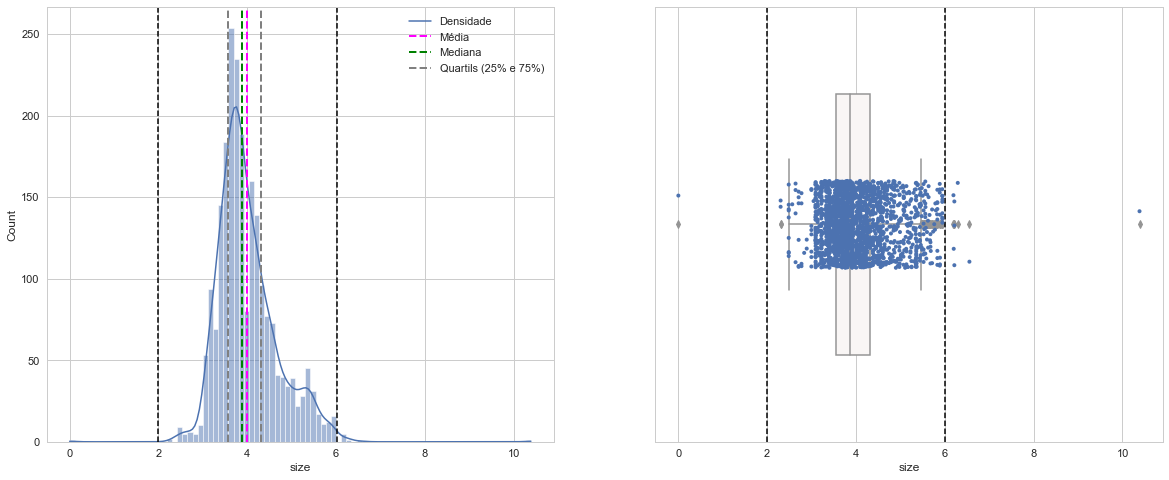


            Média: 4.0
            Mediana: 3.87
            Size data: 2221 


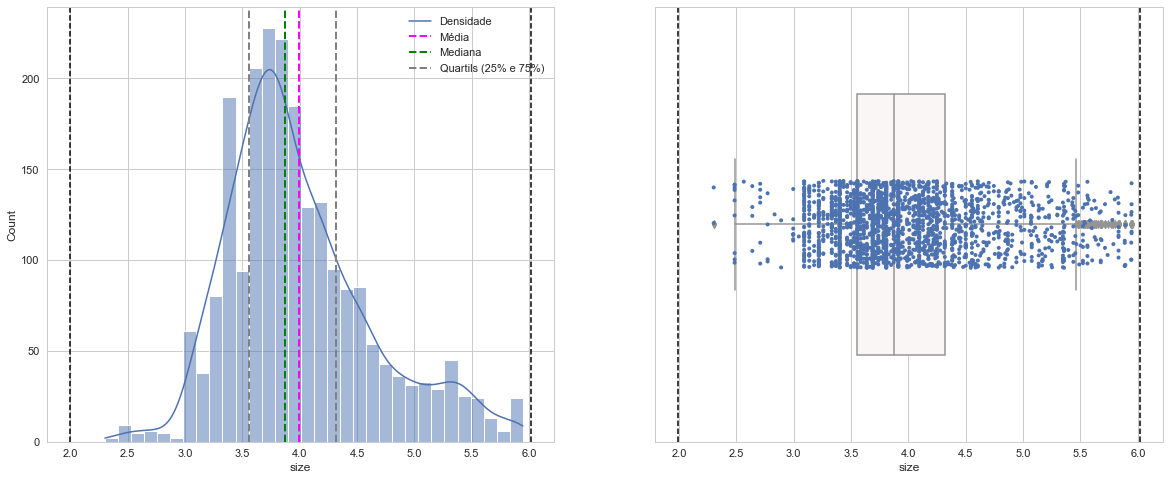

========== size - Escala padrao depois do filtro ==========

        Média: 69.21
        Mediana: 48.0
        Size data: 2221 


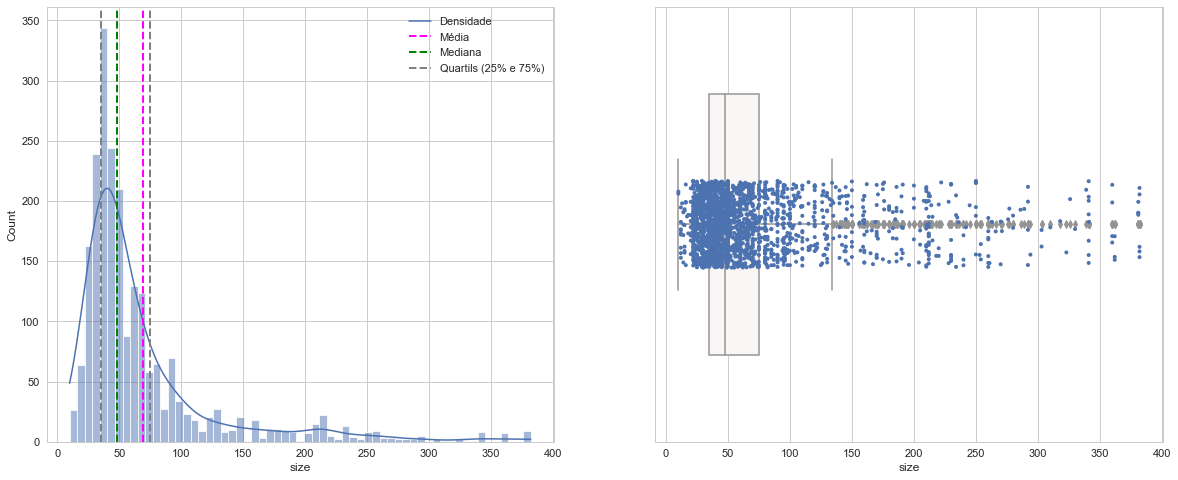

In [20]:
df_cleaned = plot_dist(df_cleaned, 'size', std=std, plot=True)

========== condominio - LOG ==========

            Média: 6.4
            Mediana: 6.32
            Size data: 2221 


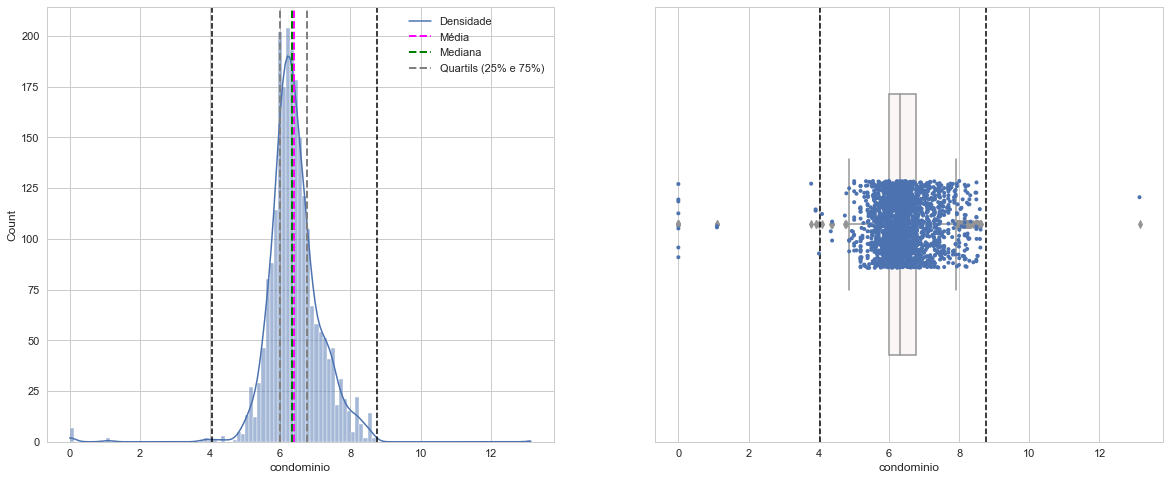


            Média: 6.43
            Mediana: 6.33
            Size data: 2207 


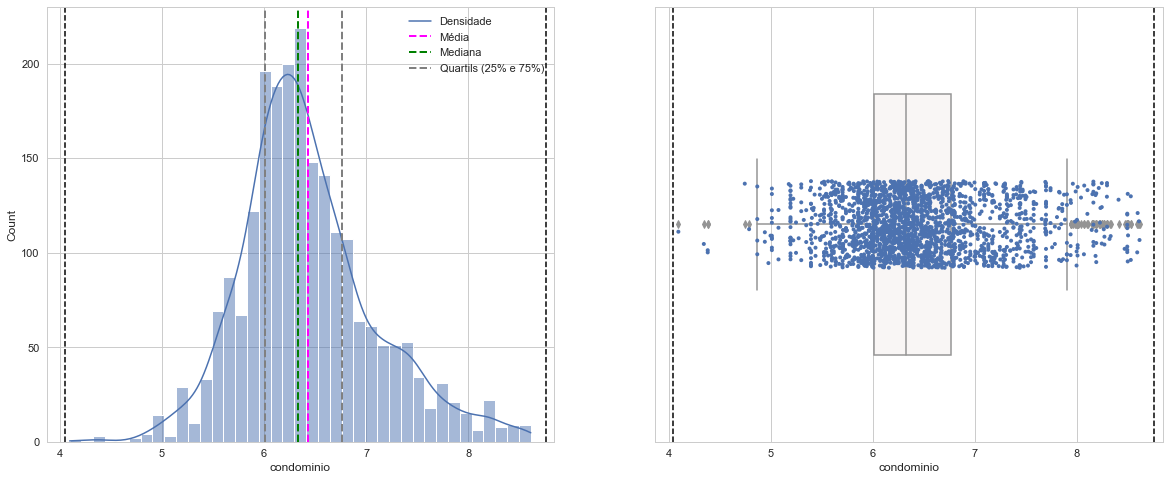

========== condominio - Escala padrao depois do filtro ==========

        Média: 794.53
        Mediana: 560.0
        Size data: 2207 


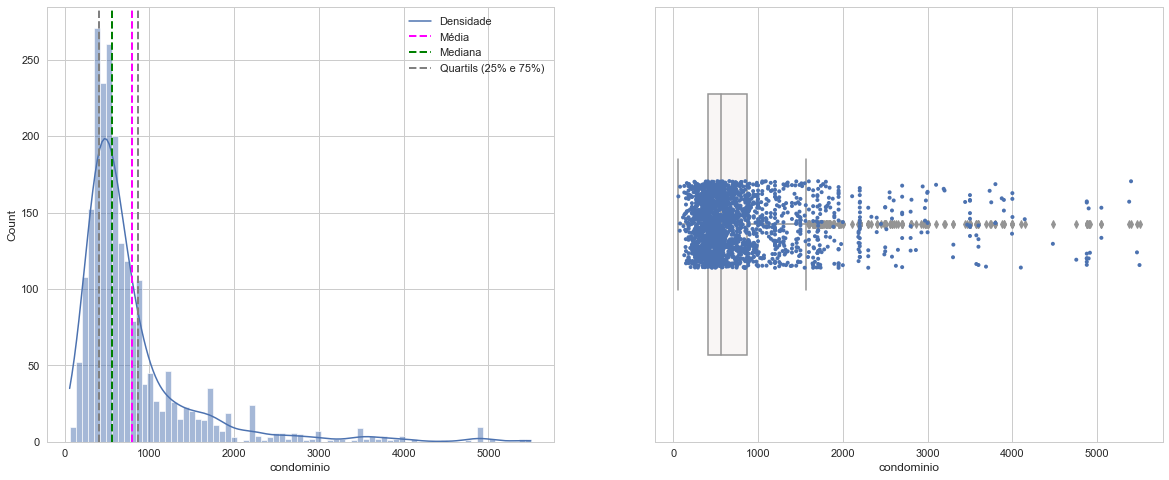

In [21]:
df_cleaned = plot_dist(df_cleaned, 'condominio', std=std, plot=True)

========== price - LOG ==========

            Média: 7.74
            Mediana: 7.65
            Size data: 2207 


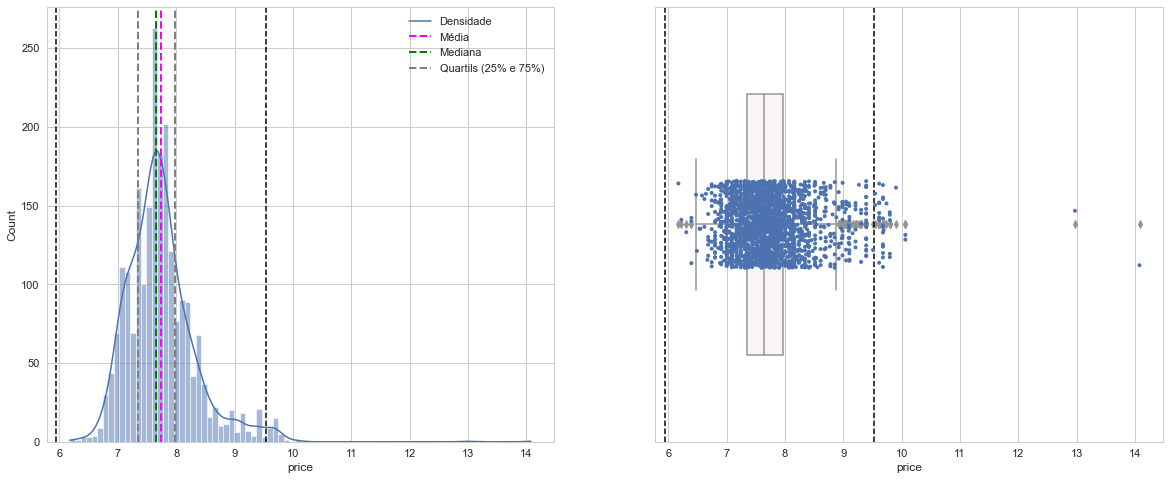


            Média: 7.7
            Mediana: 7.65
            Size data: 2171 


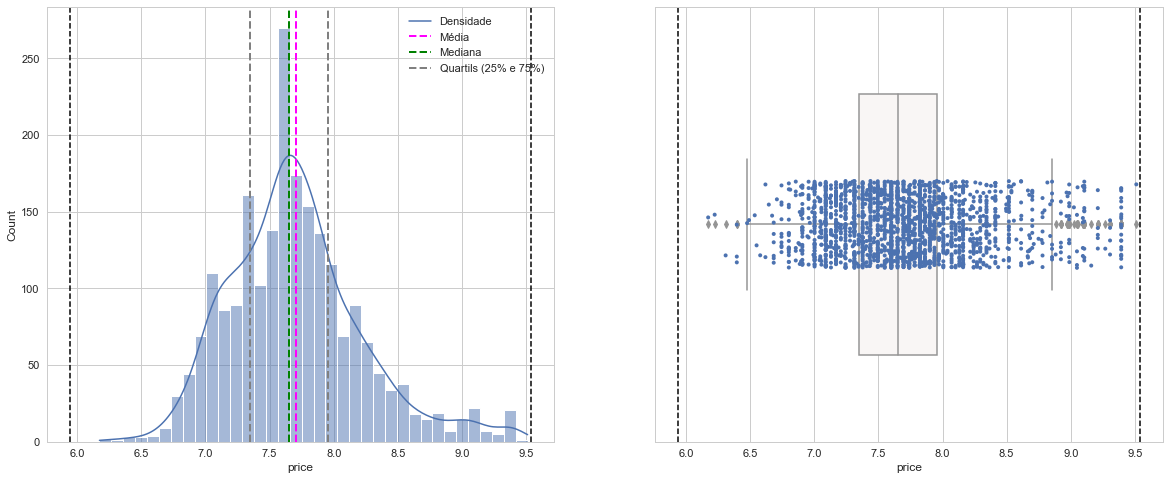

========== price - Escala padrao depois do filtro ==========

        Média: 2583.8
        Mediana: 2100.0
        Size data: 2171 


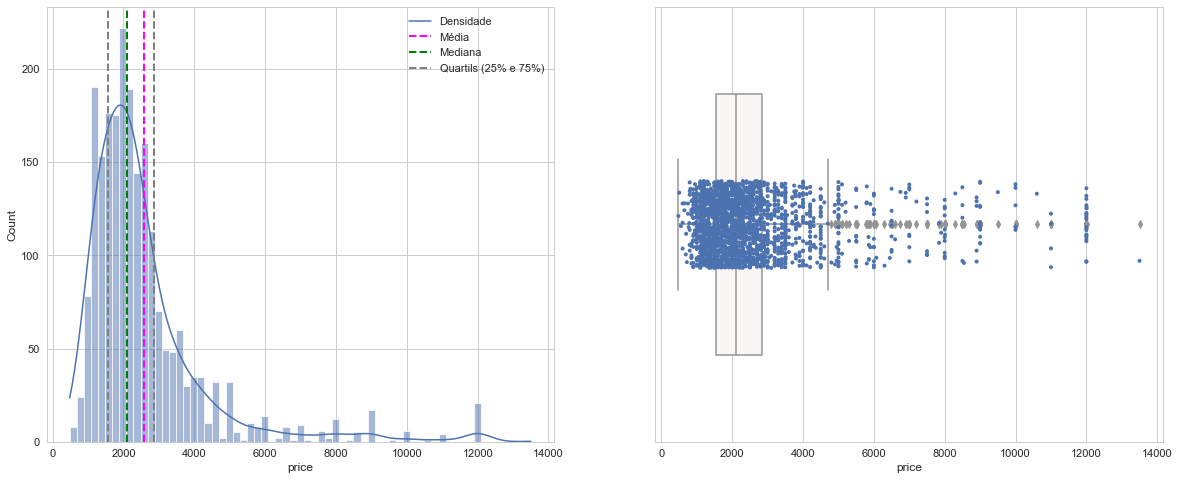

In [22]:
df_cleaned = plot_dist(df_cleaned, 'price', std=std)

In [23]:
df_cleaned.describe()

,list_id,price,condominio,rooms,bathrooms,garage_spaces,size,pictures,zipcode,latitude,longitude,altitude,iptu
count,2.171000e+03,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000,2.171000e+03,2171.000000,2171.000000,2171.000000,2171.0
mean,9.411587e+08,2583.801935,748.438968,1.574850,1.425150,0.734224,65.732381,16.095348,1.348904e+06,-23.546058,-46.633797,757.343817,0.0
std,2.500278e+07,1783.656968,603.475054,0.792414,0.822099,0.732915,53.231377,4.804053,3.494547e+05,0.026160,0.025530,47.816212,0.0
min,6.425155e+08,480.000000,60.000000,1.000000,1.000000,0.000000,10.000000,1.000000,1.005020e+06,-23.683450,-46.772955,-23.571600,0.0
25%,9.379092e+08,1550.000000,404.000000,1.000000,1.000000,0.000000,35.000000,13.000000,1.220030e+06,-23.555515,-46.643756,760.000000,0.0
50%,9.498674e+08,2100.000000,552.000000,1.000000,1.000000,1.000000,47.000000,18.000000,1.306030e+06,-23.548000,-46.636000,760.000000,0.0
75%,9.530888e+08,2850.000000,849.000000,2.000000,2.000000,1.000000,72.000000,20.000000,1.333011e+06,-23.540620,-46.624121,760.000000,0.0
max,9.551214e+08,13500.000000,5400.000000,4.000000,5.000000,5.000000,360.000000,21.000000,4.108130e+06,-23.311840,-46.378387,828.000000,0.0


In [24]:
now = datetime.now().strftime("%Y-%m-%d_%H%M%S") # Data e horario
df_cleaned.to_csv(f'./data/03_cleaned_df/cleaned_df_{now}.csv', sep='|',  index=False) # Cria o dataframe